# Projekt Terawatt

*von Team Coding Agents*

Simulation der Systemdelays am Energiecampus.

In [9]:
import iplantuml

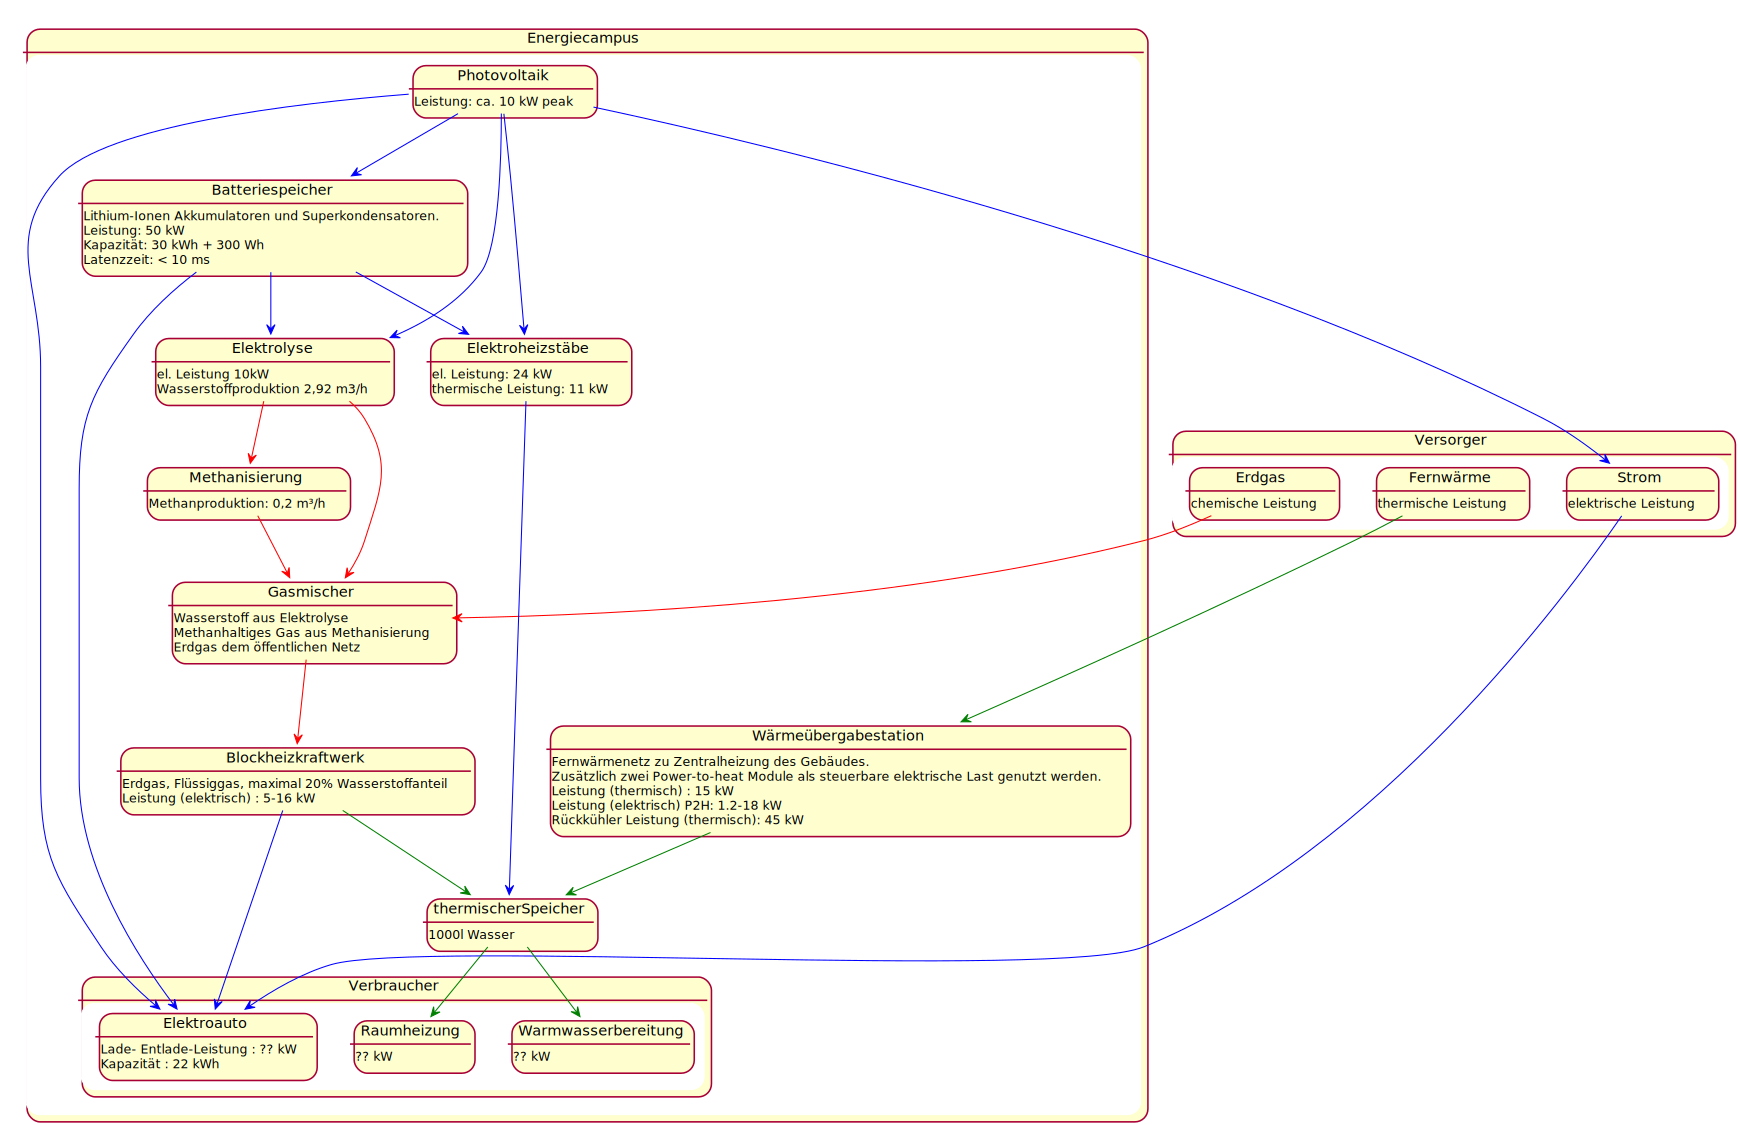

In [26]:
%%plantuml overview

@startuml
skinparam dpi 100


state Energiecampus{

    state Verbraucher {
        Elektroauto : Lade- Entlade-Leistung : ?? kW
        Elektroauto : Kapazität : 22 kWh
        Raumheizung : ?? kW
        Warmwasserbereitung : ?? kW
    }                  
    
    Gasmischer : Wasserstoff aus Elektrolyse
    Gasmischer : Methanhaltiges Gas aus Methanisierung
    Gasmischer : Erdgas dem öffentlichen Netz
    
    Wärmeübergabestation : Fernwärmenetz zu Zentralheizung des Gebäudes. 
    
    Photovoltaik : Leistung (elektrisch) : ca. 10 kW peak
}

state Versorger{
    Strom -[#blue]-> Elektroauto 
    Strom : elektrische Leistung
    Erdgas -[#red]-> Gasmischer
    Erdgas : chemische Leistung
    Fernwärme -[#green]-> Wärmeübergabestation
    Fernwärme : thermische Leistung
}

state Energiecampus{
    
    Blockheizkraftwerk -[#green]-> thermischerSpeicher
    Blockheizkraftwerk -[#blue]-> Elektroauto
    Blockheizkraftwerk : Erdgas, Methanhaltiges Gas, Wasserstoff (maximal 20%)
    Blockheizkraftwerk : Leistung (elektrisch) : 5-16 kW

    Gasmischer -[#red]-> Blockheizkraftwerk

    Wärmeübergabestation : Zusätzlich zwei Power-to-heat Module als steuerbare elektrische Last genutzt werden. 
    Wärmeübergabestation : Leistung (thermisch) : 15 kW
    Wärmeübergabestation : Leistung (elektrisch) P2H: 1.2-18 kW
    Wärmeübergabestation : Rückkühler Leistung (thermisch): 45 kW
    Wärmeübergabestation -[#green]-> thermischerSpeicher

    Batteriespeicher : Lithium-Ionen Akkumulatoren und Superkondensatoren. 
    Batteriespeicher : Leistung (elektrisch): 50 kW
    Batteriespeicher : Kapazität (elektrisch): 30 kWh + 300 Wh
    Batteriespeicher : Latenzzeit: < 10 ms
    Batteriespeicher -[#blue]-> Elektroauto

    Photovoltaik -[#blue]-> Strom
    Photovoltaik -[#blue]-> Elektroauto
    Photovoltaik -[#blue]-> Batteriespeicher
    Photovoltaik -[#blue]-> Elektrolyse
    Photovoltaik -[#blue]-> Elektroheizstäbe
                                                            
    Elektrolyse : Leistung (elektrisch) : 10 kW
    Elektrolyse : Wasserstoffproduktion : 2.92 m³/h
    Batteriespeicher -[#blue]-> Elektrolyse
    Elektrolyse -[#red]-> Gasmischer
    Elektrolyse -[#red]-> Methanisierung

    Methanisierung : Methanproduktion: 0.2 m³/h
    Methanisierung -[#red]-> Gasmischer

    thermischerSpeicher -[#green]-> Warmwasserbereitung
    thermischerSpeicher -[#green]-> Raumheizung
    thermischerSpeicher : 1000 l Wasser

    Elektroheizstäbe : Leistung (elektrisch) : 24 kW
    Elektroheizstäbe : Leistung (thermisch) : 11 kW
    Elektroheizstäbe -[#blue]-> thermischerSpeicher
                                                                                
    Batteriespeicher -[#blue]-> Elektroheizstäbe
}

@enduml 

<img src="overview.svg" alt="Overview" height="600">

In [34]:
# globals.py
timestep = 1  # second

# basic.py
class Power:
    def __init__(self):
        self.chemical = 0
        self.thermal = 0
        self.electrical = 0
        self.solar = 0

class Energy:
    def __init__(self):
        self.chemical = 0
        self.thermal = 0
        self.electrical = 0

class State:
    def __init__(self):
        self.produce = False
        self.consume = False

class Device:
    def __init__(self):
        self.state = State()
        self.energy_now = Energy()
        self.energy_max = Energy()
        self.power = Power()  # For diagnosis

    def update(self, power, state=None):
        if state == 'produce':
            self.state.produce = True
            self.state.consume = False
        elif state == 'consume':
            self.state.produce = False
            self.state.consume = True
        elif state == 'both':
            self.state.produce = True
            self.state.consume = True
        elif state == 'off':
            self.state.produce = False
            self.state.consume = False

        self.power = power  # Store input power for diagnosis
        return power

In [38]:
# cogeneration.py
class Cogeneration(Device):
    temperature = 0  # Some internal conversion variable

    def update(self, power):
        super().update(power)

        if (self.energy_now.electrical>0) and (power.electrical==0):
            self.energy_now.electrical -= 0.01
            self.power.electrical = 0.01


# battery.py
class Battery(Device):
    """
    Charge time for accumulator = (capacity of accumulator in mAh) / (charging current in mA) * 1.3
    We can use the power directly since the voltage cancels out.
    """
    def __init__(self):
        super().__init__()  # parent init

        self.state.produce = False
        self.state.consume = True

        self.super_cap_current_energy = 0
        self.super_cap_max_energy = 300
        self.battery_current_energy = 0
        self.battery_max_energy = 30000
        self.max_power = 50000

        self.energy_now.electrical = 0
        self.energy_max.electrical = 30300
    
    def update(self, power, state=None):
        super().update(power)
        
        if self.state.consume:
            power = self._do_consume(power)
        
        if self.state.produce:
            power = self._do_produce(power)
        
        self.power = power
        return power
            

    def _do_consume(self, power):
        additional_energy = power.electrical*(timestep/3600) / 1.3
        if self.super_cap_current_energy + additional_energy < self.super_cap_max_energy:
            self.super_cap_current_energy += additional_energy
            power.electrical = 0
        elif self.battery_current_energy + additional_energy < self.battery_max_energy:
            self.battery_current_energy += additional_energy
            power.electrical = 0
        
        self.energy_now.electrical = self.super_cap_current_energy + self.super_cap_current_energy
        
        return power

    def _do_produce(self, power):
        power.electrical = self.max_power
        required_energy = power.electrical*(timestep/3600)
        if self.super_cap_current_energy - required_energy > 0:
            self.super_cap_current_energy -= required_energy
        elif self.battery_current_energy - required_energy > 0:
            self.battery_current_energy -= required_energy
        else:  # Super cap and battery are empty
            power.electrical = 0
        return power


# photovoltaic.py
class Photovoltaic(Device):
    """
    Panel size and efficiency are tuned to match 10kV peak for maximum solar power.
    """
    def __init__(self):
        super().__init__()  # parent init
        self.panel_size = 50  # square meters
        self.efficiency = 0.2  # efficiency of solar power to electrical power conversion

        self.state.produce = True
        self.state.consume = False

    def update(self, power):
        super().update(power)

        if self.state.produce:
            power = self._do_produce(power)
        
        self.power = power
        return power
    
    def _do_produce(self, power):
        power.electrical = self.efficiency * self.panel_size * power.solar
        return power


# sun.py
import numpy as np

class Sun(Device):
    """
    Maximum power is an estimate.
    """
    def __init__(self):
        super().__init__()  # parent init
        self.maximum_power = 1000  # Watt per square meter
        
        self.state.produce = True
        self.state.consume = False

    def gaussian(self, x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    def update(self, hour_of_day=12, state=None):

        if self.state.produce:
            # Model according to summer days in Germany
            self.power.solar = np.floor(1000 * self.gaussian(hour_of_day, 12, 2))  # output in Watt per square meter
        
        return self.power


# provider.py
class Provider(Device):
    """
    Provider is a source and sink.
    As sink it just takes all surplus power and we can monitor the money created.
    """

    def __init__(self):
        super().__init__()  # parent init
        self.power.electrical = 230 * 16  # Volt * Ampere
        
        self.state.produce = True
        self.state.consume = True

    def update(self, power, state=None):
        super().update(power)
        
        if self.state.consume:
            additional_energy = power.electrical*(timestep/3600)
            self.energy_now.electrical += additional_energy
            power.electrical = 0
            
        if self.state.produce:
            self.power.electrical = 230 * 16  # Volt * Ampere
            power = self.power
        else:
            # Internal power production zero
            # return power in if not consumed before
            self.power.electrical = 0
        
        return power


# car.py
class Car(Device):
    """
    An electric car as consumer for the power produced.
    """

    def __init__(self):
        super().__init__()  # parent init
        self.energy_now.electrical = 0
        self.energy_max.electrical = 22000

        self.state.produce = False
        self.state.consume = True


    def update(self, power, state=None):
        super().update(power)

        if self.state.consume:
            additional_energy = power.electrical*(timestep/3600) / 1.3
            if self.energy_now.electrical + additional_energy < self.energy_max.electrical:
                self.energy_now.electrical += additional_energy
                power.electrical = 0
        
        return power
        


In [42]:
# network.py
import datetime

sun = Sun()
photovoltaic = Photovoltaic()
battery = Battery()
car = Car()
provider = Provider()
time = datetime.datetime.now()

for i in range(3600*6):
    time += datetime.timedelta(0,1) # days, seconds

    sun.update(hour_of_day=time.hour)
    
    pv_distribution = photovoltaic.update(sun.power)
    
    pv_distribution = car.update(pv_distribution)
    pv_distribution = battery.update(pv_distribution)
    provider.update(pv_distribution)
 
    print('time', time)
    print('solar power', sun.power.solar)
    print('super cap', battery.super_cap_current_energy)
    print('battery', battery.battery_current_energy)
    print('car', car.energy_now.electrical)
    print('provider', provider.energy_now.electrical)
    print('--------------------------------------')
    



time 2016-09-17 23:43:32.763853
solar power 0.0
super cap 0.0
battery 0
car 0.0
provider 0.0
--------------------------------------
time 2016-09-17 23:43:33.763853
solar power 0.0
super cap 0.0
battery 0
car 0.0
provider 0.0
--------------------------------------
time 2016-09-17 23:43:34.763853
solar power 0.0
super cap 0.0
battery 0
car 0.0
provider 0.0
--------------------------------------
time 2016-09-17 23:43:35.763853
solar power 0.0
super cap 0.0
battery 0
car 0.0
provider 0.0
--------------------------------------
time 2016-09-17 23:43:36.763853
solar power 0.0
super cap 0.0
battery 0
car 0.0
provider 0.0
--------------------------------------
time 2016-09-17 23:43:37.763853
solar power 0.0
super cap 0.0
battery 0
car 0.0
provider 0.0
--------------------------------------
time 2016-09-17 23:43:38.763853
solar power 0.0
super cap 0.0
battery 0
car 0.0
provider 0.0
--------------------------------------
time 2016-09-17 23:43:39.763853
solar power 0.0
super cap 0.0
battery 0
car 

In [40]:
m = Input()
n = Input()

n.chemisch = 6

print(m.chemisch)
print(n.chemisch)
print(Input.chemisch)

NameError: name 'Input' is not defined

In [ ]:
class BlockheizRestore:
    def restore(blockheiz):
        # Load data
        # foreach d in data:
        #    blockheiz.conversion(d)

In [ ]:
class Main:
    # List of devices
    # Sun is a device
    devices_usedBy={}
    devices_usedBy[block1]=bmw1
    # List of externals
    # List of output for next step
    # List of state of current step
    # List of input current step
    
    # Magic knowledge about connecting devices
    # foreach d in devices:
    #     foreach dev in devices_usedBy[d]:
    #         dev.conversion(d.power_out)
    
    # Update externals